In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path,dir,files = next(os.walk('/content/drive/Shareddrives/Machine Learning/DeGreenProject/Dataset/Train/Black Soil'))
file_count = len(files)
print("Number of images: ",file_count)

Number of images:  148


In [ ]:
image_shape = (224, 224)
TRAINING_DIR = "/content/drive/Shareddrives/Machine Learning/DeGreenProject/Dataset/Train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/drive/Shareddrives/Machine Learning/DeGreenProject/Dataset/Test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR, target_size=image_shape,class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=image_shape,class_mode='categorical',batch_size=64)

Found 519 images belonging to 5 classes.
Found 212 images belonging to 5 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                              include_top=False,
                                              weights='imagenet')

# Membekukan lapisan-lapisan di base model
base_model.trainable = False

# Buat model baru di atas MobileNetV2 base
Model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(5, activation='softmax')  # 5 output neurons untuk 5 kelas dengan aktivasi softmax
])

Model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_28 (Dense)            (None, 512)               655872    
                                                                 
 dense_29 (Dense)            (None, 128)               65664     
                                                                 
 dense_30 (Dense)            (None, 256)               33024     
                                                                 
 dropout_9 (Dropout)         (None, 256)              

In [ ]:
from tensorflow.keras.optimizers import RMSprop

Model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.95): # Experiment with changing this value
      print("\nReached 95% Validation Accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = Model.fit(train_generator, epochs = 50,
                          validation_data=validation_generator, callbacks= [callbacks])

Epoch 1/50
9/9 [==============================] - 45s 5s/step - loss: 1.8065 - acc: 0.3083 - val_loss: 1.2343 - val_acc: 0.4906
Epoch 2/50
9/9 [==============================] - 42s 5s/step - loss: 1.2285 - acc: 0.4952 - val_loss: 1.1160 - val_acc: 0.4764
Epoch 3/50
9/9 [==============================] - 50s 6s/step - loss: 0.8997 - acc: 0.6416 - val_loss: 0.7639 - val_acc: 0.7358
Epoch 4/50
9/9 [==============================] - 51s 6s/step - loss: 0.7681 - acc: 0.6821 - val_loss: 0.7031 - val_acc: 0.7406
Epoch 5/50
9/9 [==============================] - 50s 6s/step - loss: 0.6846 - acc: 0.7206 - val_loss: 0.8074 - val_acc: 0.7028
Epoch 6/50
9/9 [==============================] - 50s 6s/step - loss: 0.5991 - acc: 0.7881 - val_loss: 0.5960 - val_acc: 0.7877
Epoch 7/50
9/9 [==============================] - 40s 4s/step - loss: 0.6103 - acc: 0.7592 - val_loss: 0.6009 - val_acc: 0.7783
Epoch 8/50
9/9 [==============================] - 42s 5s/step - loss: 0.5406 - acc: 0.7938 - val_loss: 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


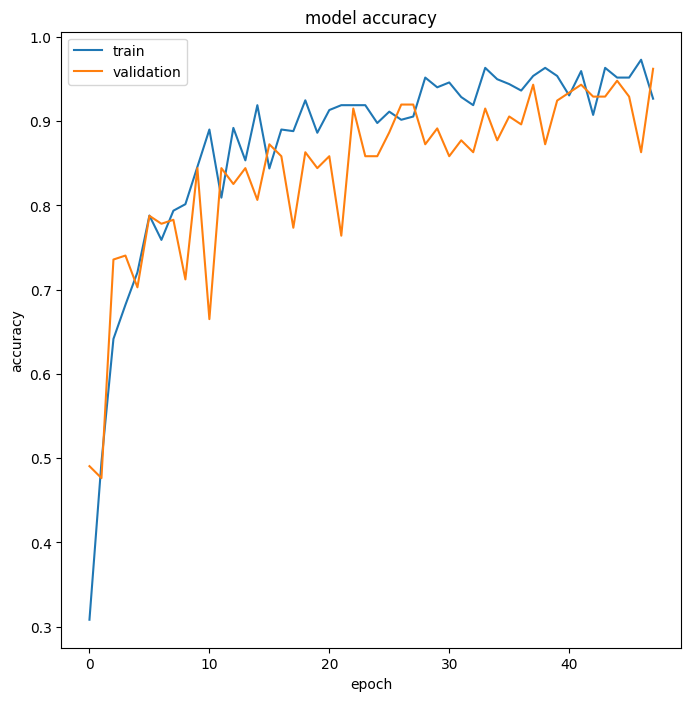

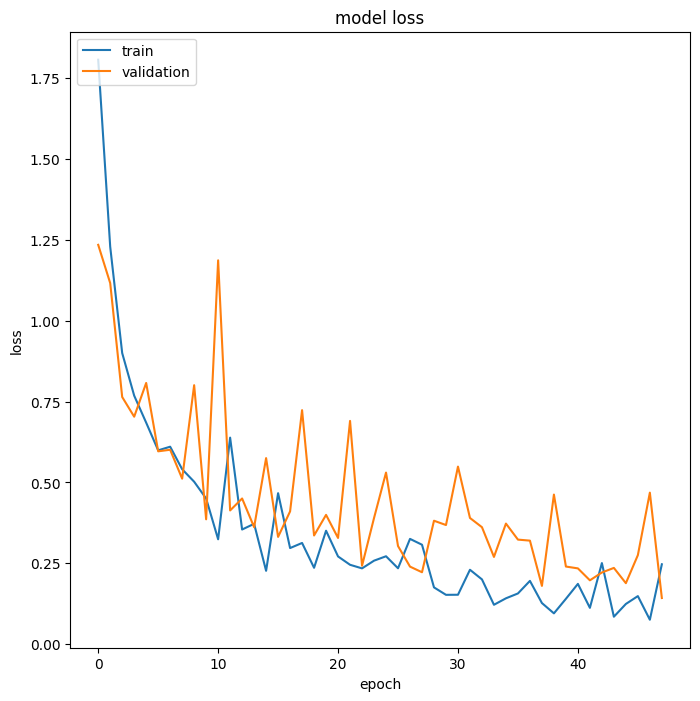

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = Model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0][0]>0.7:
    print(fn + " is a Aluvial Soil")
  elif classes[0][1]>0.7:
    print(fn + " is a Black Soil")
  elif classes[0][2]>0.7:
    print(fn + " is a Cinder Soil")
  elif classes[0][3]>0.7:
    print(fn + " is a Clay Soil")
  else:
    print(fn + " is a Red Soil")

Saving red.jpeg.jpg to red.jpeg (2).jpg
1/1 [==============================] - 1s 950ms/step
[2.9613896e-06 1.7701106e-07 8.1895850e-09 7.3966666e-10 9.9999690e-01]
red.jpeg (2).jpg is a Red Soil


In [ ]:
Model.save('soil_model3.h5')